<a href="https://colab.research.google.com/github/abelowska/mlNeuro/blob/main/MLN_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization

* Regularization is a process that changes the result answer to be "simpler"
* Regularization is a set of methods for reducing overfitting in machine learning, when we have a large set of features and/or small amount of training samples
* It constrains/regularizes or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model
* Regularization increase bias (limits flexibility of the model to learn from data) but decrease variance (the model’s sensitivity to specific sets of data)



**Lasso Regression:**
$L_1 = ||y - Xβ||^2 + λ ∑_{i=1}^p|β_i|$


**Ridge Regression:**
$L_2 = ||y - Xβ||^2 + λ ∑_{i=1}^pβ_i^2$

---
**Identifying predictive variables**

Up to now, we have been striving to maximize classification scores. Our goal has been to obtain the best model, regardless of its explainability.

Now, consider the following scenario: imagine you have a paradigm known as the stop-signal task. In this paradigm, the GO stimulus is presented initially, and sometimes, the STOP stimulus follows the GO. In such situations, a person must inhibit an already initiated response. According to the horse-racing models of stop signal [], the success of the inhibitory process depends on two independent processes: GO stimulus processing and STOP stimulus processing.

The rationale is simple: the stronger the GO stimulus processing, the stronger the STOP stimulus processing must be to overcome the GO binding for successful inhibition. Thus, according to the horse-race model, successful inhibition always results from the strength of both GO and STOP processing. In other words, we can imagine the following situations:

1. Strong GO, strong STOP ----> successful inhibition
2. Strong GO, weak STOP ----> unsuccessful inhibition
3. Weak GO, strong STOP ----> successful inhibition
4. Weak GO, weak STOP ----> (un)successful inhibition

This is only a hypothesis, although there is a significant amount of evidence in favor of it.

**Now, consider how you can use machine learning to try to prove or disprove this theory**

In [ ]:
!pip install mne

Imports

In [171]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
from mne.datasets import eegbci
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter, CSP, Vectorizer


from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA, FastICA
from mne.datasets import sample
import re
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Read SST dataset

In [395]:
epochs = mne.read_epochs('./simulated_sst-epo.fif')
epochs

Reading /content/simulated_2_sst-epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     898.44 ms
        0 CTF compensation matrices available
Not setting metadata
660 matching events found
No baseline correction applied
0 projection items activated


Number of events,660
Events,go: 285stop/succesfull: 213stop/unsuccesfull: 162
Time range,-0.102 – 0.898 s
Baseline,off


### Inspect the data

No projector specified for this dataset. Please consider the method self.add_proj.


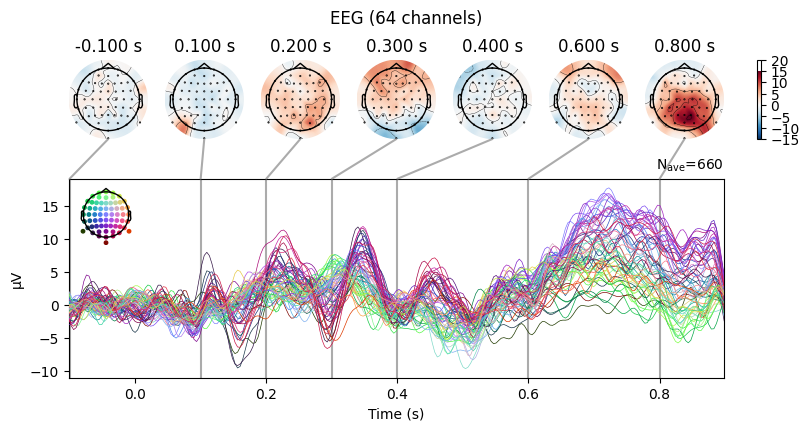

In [397]:
# plot all data
fig = epochs.average().plot_joint(times=[-.1, .1, .2, .3, .4, .6, .8])

No projector specified for this dataset. Please consider the method self.add_proj.


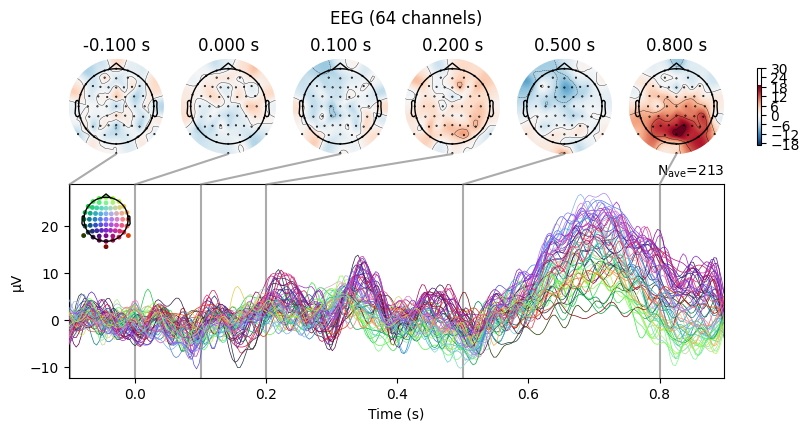

No projector specified for this dataset. Please consider the method self.add_proj.


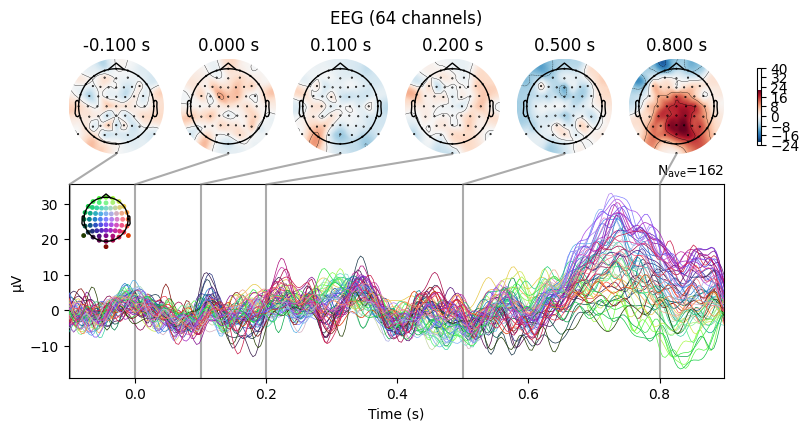

No projector specified for this dataset. Please consider the method self.add_proj.


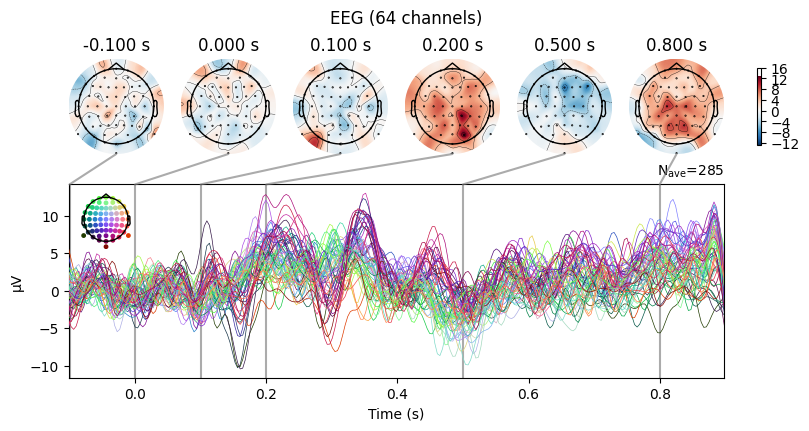

In [402]:
# joint-plots per condition
fig = epochs['stop/succesfull'].average().plot_joint(times=[-.1, 0, .1, .2, .5, .8])
fig = epochs['stop/unsuccesfull'].average().plot_joint(times=[-.1, 0, .1, .2, .5, .8])
fig = epochs['go'].average().plot_joint(times=[-.1, 0, .1, .2, .5, .8])

<Figure size 640x480 with 0 Axes>

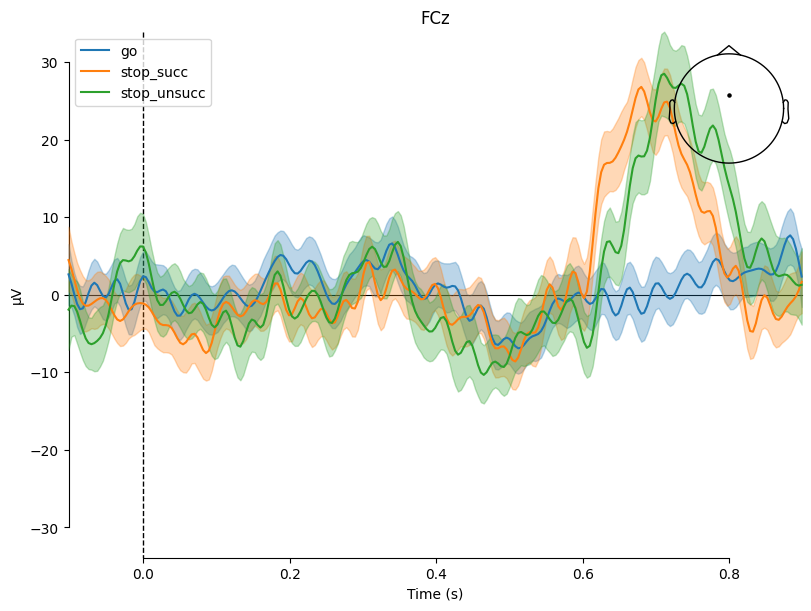

In [404]:
# wave plots per condition
picks = ['FCz']

evokeds = dict(
    go=list(epochs["go"].iter_evoked()),
    stop_succ=list(epochs["stop/succesfull"].iter_evoked()),
    stop_unsucc=list(epochs["stop/unsuccesfull"].iter_evoked()),
)

for idx, pick in enumerate(picks):
  plt.figure(idx)
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=pick)
  plt.show()

### Classification

In [405]:
def estimate_model(
    X_train,
    X_test,
    y_train,
    y_test,
    model=SVC()
):
  # fit
  model.fit(X_train, y_train)

  # predict test and train data
  y_test_predicted = model.predict(X_test)
  y_train_predicted = model.predict(X_train)

  print(f'Classification report for testing data:\n{classification_report(y_test, y_test_predicted)}')
  print(f'Classification report for training data:\n{classification_report(y_train, y_train_predicted)}')

  return model

Create train and test sets

In [406]:
def train_test_split_epochs(epochs_list, split=0.7, go=True):
  if len(epochs_list) != 1:
    train_n = int(len(epochs_list)*split)
    test_n = len(epochs_list) - train_n
    train_epochs = mne.concatenate_epochs(epochs_list[:train_n])
    test_epochs = mne.concatenate_epochs(epochs_list[-test_n:])

    X_train = train_epochs.get_data(copy=True)
    X_test = test_epochs.get_data(copy=True)
    y_train = train_epochs.events[:, -1] - 1
    y_test = test_epochs.events[:, -1] - 1

  else:
    epochs = epochs_list[0]

    X = epochs.get_data(copy=True)
    y = epochs.events[:, -1]
    if go == True:
      y = [0 if item == 0 else 1 for item in y]
    else:
      y = y

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=split,
        random_state=42,
        shuffle=True,
        stratify=y
    )


  return X_train, y_train, X_test, y_test

Prepare data

In [431]:
# define data
tmin = -0.1
tmax = 0
data = [epochs['stop'].copy().crop(tmin=tmin, tmax=tmax)]

In [432]:
# define X and y sets
X_train, y_train, X_test, y_test = train_test_split_epochs(
    data,
    split=0.7,
    go=False
)

print(X_train.shape)

(262, 64, 27)


Perform classification

In [433]:
n_components = 4

model = make_pipeline(
    # UnsupervisedSpatialFilter(PCA(n_components), average=False),
    Vectorizer(),  # vectorize across time and channels to n_samples, n_features
    StandardScaler(),
    LogisticRegression(penalty='l1', C=100, solver='liblinear'),
)

fitted_model = estimate_model(
    X_train,
    X_test,
    y_train,
    y_test,
    model=model
)

Classification report for testing data:
              precision    recall  f1-score   support

           1       0.60      0.56      0.58        64
           2       0.47      0.51      0.49        49

    accuracy                           0.54       113
   macro avg       0.54      0.54      0.54       113
weighted avg       0.54      0.54      0.54       113

Classification report for training data:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       149
           2       1.00      1.00      1.00       113

    accuracy                           1.00       262
   macro avg       1.00      1.00      1.00       262
weighted avg       1.00      1.00      1.00       262



Extract estimated coefficients to see which regions/features were crutial for classification

In [439]:
coeffs = fitted_model[-1].coef_
coeffs_reshaped = coeffs.reshape(64, -1)

index = epochs.info['ch_names']
# index = ['PCA1', 'PCA2', 'PCA3', 'PCA4']
columns = np.linspace(tmin, tmax, X_train.shape[-1], dtype=float).round(3)

df = pd.DataFrame(coeffs_reshaped, index=index, columns=columns)

Plot coefficients

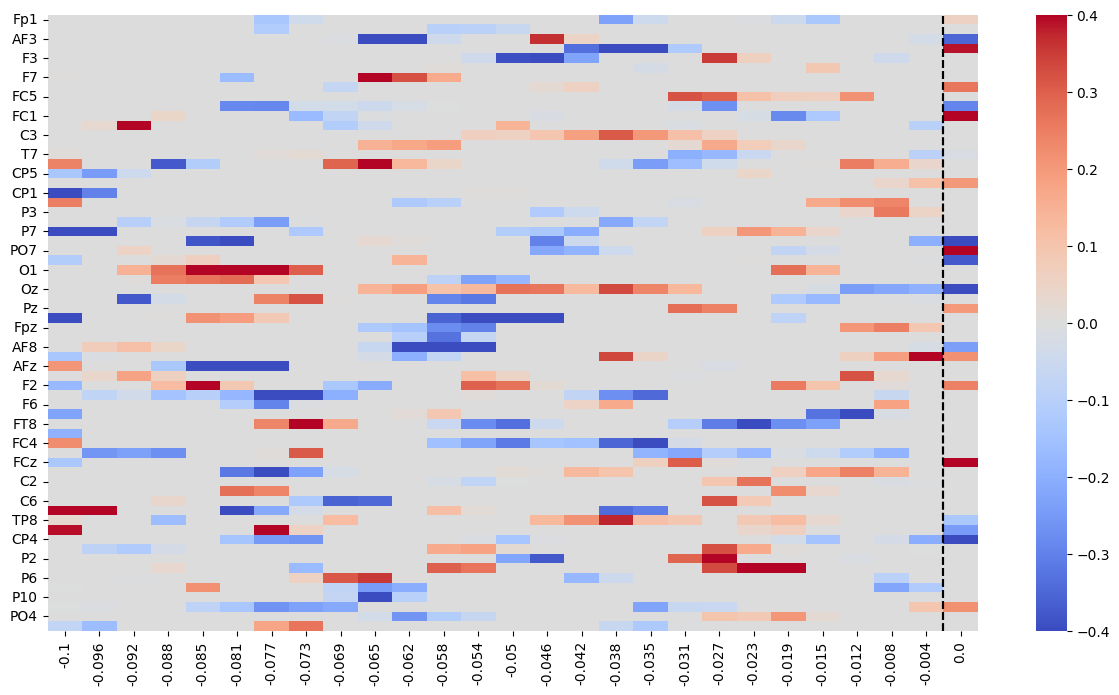

In [438]:
plt.figure(figsize = (15,8))

ax = sns.heatmap(
    df,
    center=0,
    cmap = 'coolwarm',
    vmin=-0.4,
    vmax=0.4
)

# draw zero point
timepoints_in_secs = [float(col) for col in df.columns]
zero_idx = min(range(len(timepoints_in_secs)), key=lambda i: abs(timepoints_in_secs[i] - 0))
ax.axvline(x=zero_idx, color='black', linestyle='--')

# draw ~ STOP stimuli point
timepoints_in_secs = [float(col) for col in df.columns]
stop_idx = min(range(len(timepoints_in_secs)), key=lambda i: abs(timepoints_in_secs[i] - 0.1))
ax.axvline(x=stop_idx, color='black', linestyle='--')

plt.show()

Plot PCA spatial filters

Spatial filter: 1


<Figure size 640x480 with 0 Axes>

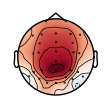

Spatial filter: 2


<Figure size 640x480 with 0 Axes>

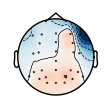

Spatial filter: 3


<Figure size 640x480 with 0 Axes>

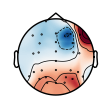

Spatial filter: 4


<Figure size 640x480 with 0 Axes>

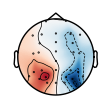

In [ ]:
pca_estimator = fitted_model[0].estimator

for i in np.arange(0, n_components):
  # create canvas
  plt.figure(i)
  print(f'Spatial filter: {i+1}')

  # get data of i-th component
  spatial_data = pca_estimator.components_[i]
  mne.viz.plot_topomap(
      spatial_data,
      pos=epochs.info,
      show=False
  )

  plt.show()

---
## Read ERP Core data

In [526]:
epochs = mne.read_epochs('./simulated_flanker-epo.fif')
epochs

Reading /content/simulation_flanker-epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     400.39 ms
        0 CTF compensation matrices available
Adding metadata with 13 columns
607 matching events found
No baseline correction applied
0 projection items activated


Number of events,607
Events,correct: 337incorrect: 270
Time range,-0.100 – 0.400 s
Baseline,-0.100 – 0.000 s


### Inspect data

No projector specified for this dataset. Please consider the method self.add_proj.


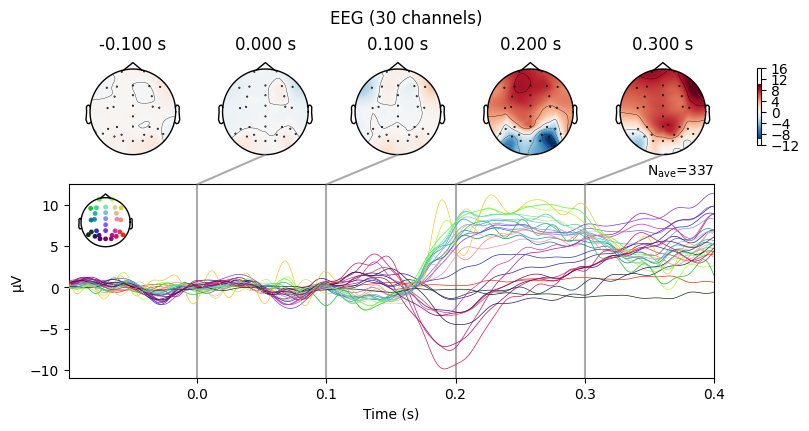

No projector specified for this dataset. Please consider the method self.add_proj.


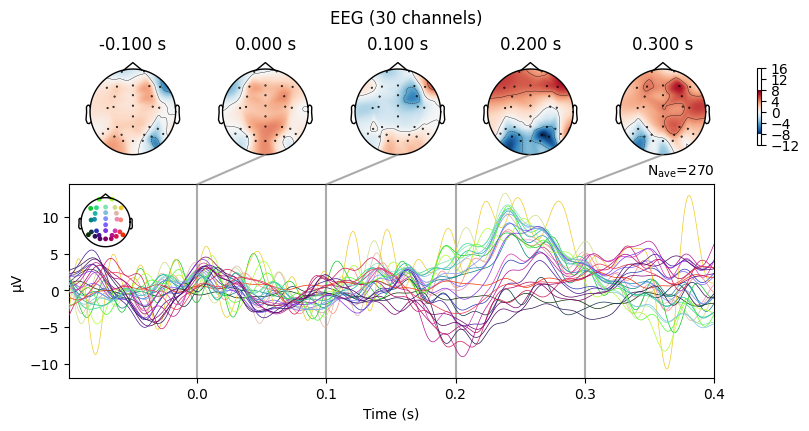

In [527]:
# joint-plots per condition
fig = epochs['correct'].average().plot_joint(times=[-.1, 0, .1, .2, .3])
fig = epochs['incorrect'].average().plot_joint(times=[-.1, 0, .1, .2, .3])

<Figure size 640x480 with 0 Axes>

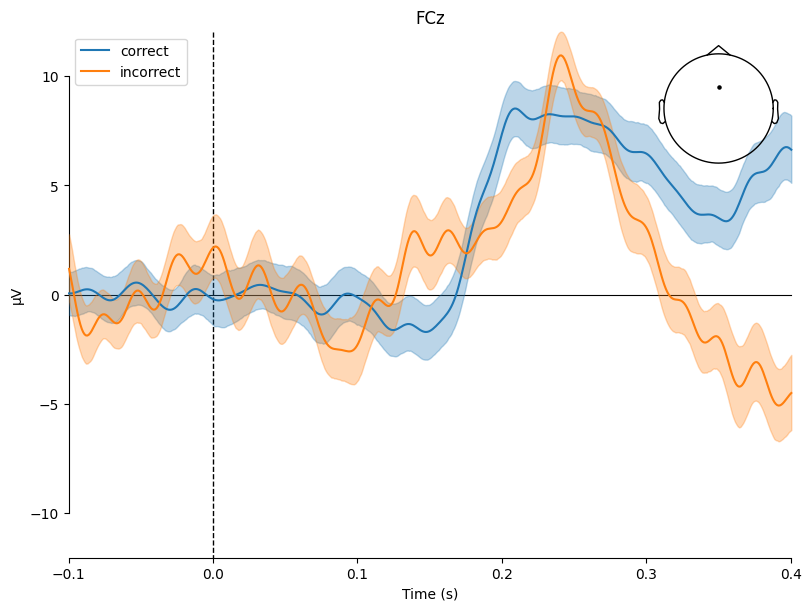

<Figure size 640x480 with 0 Axes>

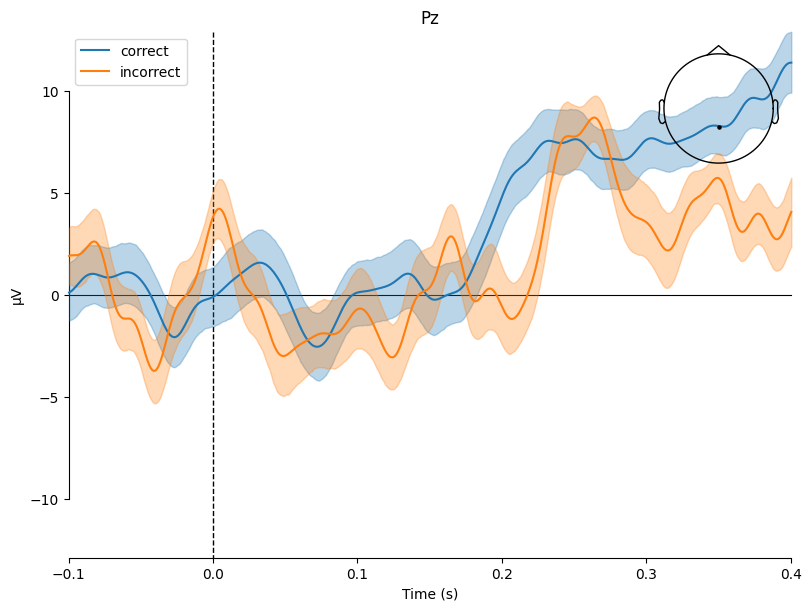

In [530]:
# wave plots per condition
picks = ['FCz', 'Pz']

evokeds = dict(
    correct=list(epochs["correct"].iter_evoked()),
    incorrect=list(epochs["incorrect"].iter_evoked()),
)

for idx, pick in enumerate(picks):
  plt.figure(idx)
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=pick)
  plt.show()

### Classification

In [531]:
def estimate_model(
    X_train,
    X_test,
    y_train,
    y_test,
    model=SVC()
):
  # fit
  model.fit(X_train, y_train)

  # predict test and train data
  y_test_predicted = model.predict(X_test)
  y_train_predicted = model.predict(X_train)

  print(f'Classification report for testing data:\n{classification_report(y_test, y_test_predicted)}')
  print(f'Classification report for training data:\n{classification_report(y_train, y_train_predicted)}')

  return model

Create train and test sets

In [532]:
def train_test_split_epochs(epochs_list, split=0.7):
  if len(epochs_list) != 1:
    train_n = int(len(epochs_list)*split)
    test_n = len(epochs_list) - train_n
    train_epochs = mne.concatenate_epochs(epochs_list[:train_n])
    test_epochs = mne.concatenate_epochs(epochs_list[-test_n:])

    X_train = train_epochs.get_data(copy=True)
    X_test = test_epochs.get_data(copy=True)
    y_train = train_epochs.events[:, -1] - 1
    y_test = test_epochs.events[:, -1] - 1

  else:
    epochs = epochs_list[0]

    X = epochs.get_data(copy=True)
    y = epochs.events[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=split,
        random_state=42,
        shuffle=True,
        stratify=y
    )


  return X_train, y_train, X_test, y_test

Prepare data

In [547]:
# define data
tmin = -0.099
tmax = 0
data = [epochs.copy().crop(tmin=tmin, tmax=tmax).pick('eeg')]

In [548]:
# define X and y sets
X_train, y_train, X_test, y_test = train_test_split_epochs(
    data,
    split=0.7,
)

print(X_train.shape)

(424, 30, 102)


Perform classification

In [549]:
n_components = 4

model = make_pipeline(
    UnsupervisedSpatialFilter(PCA(n_components), average=False),
    Vectorizer(),  # vectorize across time and channels to n_samples, n_features
    StandardScaler(),
    LogisticRegression(penalty='l1', C=10, solver='liblinear'),
)

fitted_model = estimate_model(
    X_train,
    X_test,
    y_train,
    y_test,
    model=model
)

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       102
           1       0.62      0.69      0.65        81

    accuracy                           0.67       183
   macro avg       0.67      0.67      0.67       183
weighted avg       0.68      0.67      0.67       183

Classification report for training data:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       235
           1       0.76      0.76      0.76       189

    accuracy                           0.79       424
   macro avg       0.79      0.79      0.79       424
weighted avg       0.79      0.79      0.79       424



Extract estimated coefficients to see which regions/features were crutial for classification

In [550]:
coeffs = fitted_model[-1].coef_
coeffs_reshaped = coeffs.reshape(4, -1)

# index = epochs.info['ch_names']
index = ['PCA1', 'PCA2', 'PCA3', 'PCA4']
columns = np.linspace(tmin, tmax, X_train.shape[-1], dtype=float).round(3)

df = pd.DataFrame(coeffs_reshaped, index=index, columns=columns)

Plot coefficients

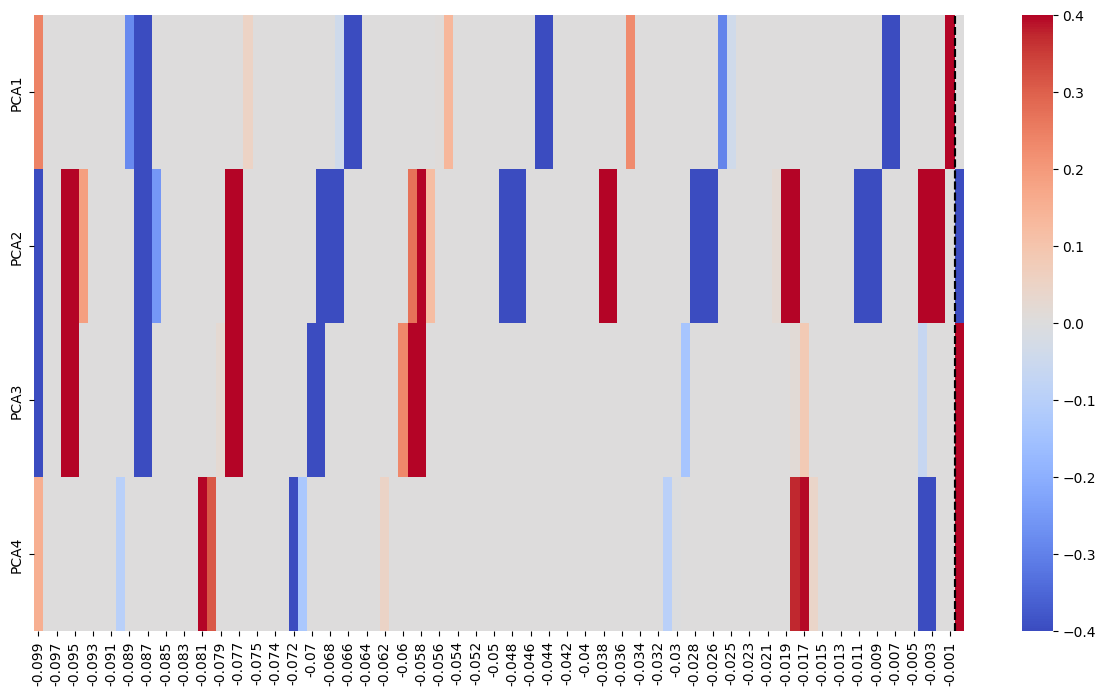

In [551]:
plt.figure(figsize = (15,8))

ax = sns.heatmap(
    df,
    center=0,
    cmap = 'coolwarm',
    vmin=-0.4,
    vmax=0.4
)

# draw zero point
timepoints_in_secs = [float(col) for col in df.columns]
zero_idx = min(range(len(timepoints_in_secs)), key=lambda i: abs(timepoints_in_secs[i] - 0))
ax.axvline(x=zero_idx, color='black', linestyle='--')

# draw ~ STOP stimuli point
timepoints_in_secs = [float(col) for col in df.columns]
stop_idx = min(range(len(timepoints_in_secs)), key=lambda i: abs(timepoints_in_secs[i] - 0.1))
ax.axvline(x=stop_idx, color='black', linestyle='--')

plt.show()

Plot PCA spatial filters

Spatial filter: 1


<Figure size 640x480 with 0 Axes>

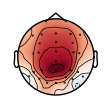

Spatial filter: 2


<Figure size 640x480 with 0 Axes>

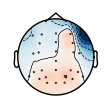

Spatial filter: 3


<Figure size 640x480 with 0 Axes>

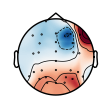

Spatial filter: 4


<Figure size 640x480 with 0 Axes>

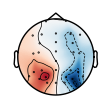

In [556]:
pca_estimator = fitted_model[0].estimator

for i in np.arange(0, n_components):
  # create canvas
  plt.figure(i)
  print(f'Spatial filter: {i+1}')

  # get data of i-th component
  spatial_data = pca_estimator.components_[i]
  mne.viz.plot_topomap(
      spatial_data,
      pos=epochs.info,
      show=False
  )

  plt.show()